In [1]:
import random
import pandas as pd
import spectral_entropy
import matplotlib
import torch
import torch.nn.functional as F
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
from rdkit import Chem
from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model
from matchms import Spectrum
from matchms.similarity import ModifiedCosine, CosineGreedy
import dreams.utils.mols as mu
import dreams.utils.spectra as su
from dreams.definitions import *
from dreams.utils.plots import init_plotting, save_fig
init_plotting()
%load_ext autoreload
%autoreload 2

In [4]:
# df = pd.read_pickle(NIST20_PKL)
df = pd.read_pickle(NIST20 / 'nist20_clean_A.pkl')
df = df[df['PRECURSOR M/Z'] < 1000]
df = df.reset_index(drop=True)

df['SMILES'] = df['ROMol'].apply(Chem.MolToSmiles)

# Compute matchms spectra
df['matchms spectrum'] = df['PARSED PEAKS'].apply(su.unpad_peak_list)
df['matchms spectrum'] = df.progress_apply(
    lambda row: Spectrum(
        mz=row['matchms spectrum'][0],
        intensities=row['matchms spectrum'][1],
        metadata={'precursor_mz': row['PRECURSOR M/Z']}
    )
, axis=1)

In [3]:
# k = 1_000
# random.seed(1)
# df_res = pd.DataFrame()
# df_res['i'] = random.sample(range(len(df)), k=k)
# df_res['j'] = random.sample(range(len(df)), k=k)
# df_res

In [4]:
# pandarallel.initialize(nb_workers=4, progress_bar=True, use_memory_fs=False)
# df_res['Morgan Tanimoto'] = df_res.parallel_apply(
#     lambda row: mu.morgan_mol_sim(df['ROMol'].iloc[row['i']], df['ROMol'].iloc[row['j']], fp_size=2048)
# , axis=1)
# df_res

In [5]:
# df_res['Morgan Tanimoto'].hist()

In [6]:
df_smiles = pd.read_pickle(MERGED_DATASETS / 'nist20_clean_MoNA_contrastive_v2_10ppm_smiles_similarities_asymmetric.pkl')

In [7]:
df_smiles = df_smiles.sample(frac=0.2, random_state=1)
df_smiles = df_smiles[df_smiles['SMILES 1'].isin(set(df['SMILES'].unique())) & df_smiles['SMILES 2'].isin(set(df['SMILES'].unique()))]
df_smiles

,SMILES 1,SMILES 2,tanimoto_similarity
46933935,COCc1cnc(C2=NC(C)(C(C)C)C(=O)N2)c(C(=O)O)c1,C=C1[C@@H]2CC[C@@]3(C)[C@H](c4ccoc4)OC(=O)C[C@...,0.127451
187963485,N#Cc1ccccc1-n1cccc1C=O,O=S1(=O)C=CCO1,0.045455
172596760,NC(=O)CC(N)C(=O)NC(CO)C(=O)O,Cc1ncc(CNC(=O)N(CCCl)N=O)c(N)n1,0.092308
190509265,O=c1[nH]c2cc(F)ccc2o1,C#CCn1cc(C=O)c2ccccc21,0.076923
78477066,O=C1C=CC(=O)O1,Nc1cc(Cl)cc(Cl)n1,0.074074
...,...,...,...
261143734,COC(=O)c1c(C)cc(OC2=C(C)C(=O)C(O)C(C)(OC)C2O)c...,CC(C)(C)c1nc(CCl)no1,0.029412
114023336,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(COC(=O)CCCCCCCCCC...,CNC(=S)NCc1ccc(Cl)cc1,0.043478
69519874,CC(C)(C)NCC(O)COc1ccccc1C1CCCC1,O=C(NC(=S)Nc1ccccc1)c1cccnc1,0.088235
263089087,OCC1(F)CCNCC1,CC(C)C(=O)Nc1cc(N)ccc1F,0.021277


In [8]:
thld = 2_500
bin_size = 0.025

df_u_tanimoto = []
for s in tqdm(range(int(1 / bin_size))):
    smiles_subdf = df_smiles[(df_smiles['tanimoto_similarity'] > s * bin_size) & (df_smiles['tanimoto_similarity'] <= (s + 1) * bin_size)]
    smiles_subdf = smiles_subdf.values.tolist()
    smiles_subdf = random.choices(smiles_subdf, k=thld)
    df_u_tanimoto_bin = []
    for smiles_0, smiles_1, tanimoto in tqdm(smiles_subdf, disable=True):
        df_u_tanimoto_bin.append([
            # NOTE: loc-based index is used here but reset_index is used at the beginning
            df[df['SMILES'] == smiles_0].sample(1, random_state=1).index[0],
            df[df['SMILES'] == smiles_1].sample(1, random_state=1).index[0],
            tanimoto
        ])
    df_u_tanimoto.extend(df_u_tanimoto_bin)
df_u_tanimoto = pd.DataFrame(df_u_tanimoto, columns=['i', 'j', 'Morgan Tanimoto'])
df_u_tanimoto

100%|██████████| 40/40 [36:17<00:00, 54.45s/it]


,i,j,Morgan Tanimoto
0,83134,123442,0.021277
1,21496,234504,0.015873
2,49154,116071,0.012658
3,161972,265258,0.018519
4,13916,40361,0.012500
...,...,...,...
99995,293151,305176,1.000000
99996,13739,13781,1.000000
99997,282787,346767,1.000000
99998,24708,24722,1.000000


<AxesSubplot: xlabel='Morgan Tanimoto', ylabel='Count'>

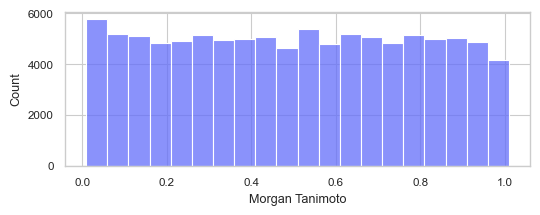

In [9]:
import seaborn as sns
init_plotting()
sns.histplot(df_u_tanimoto['Morgan Tanimoto'], binwidth=bin_size)

In [10]:
df_u_tanimoto

,i,j,Morgan Tanimoto
0,83134,123442,0.021277
1,21496,234504,0.015873
2,49154,116071,0.012658
3,161972,265258,0.018519
4,13916,40361,0.012500
...,...,...,...
99995,293151,305176,1.000000
99996,13739,13781,1.000000
99997,282787,346767,1.000000
99998,24708,24722,1.000000


In [11]:
df_res = df_u_tanimoto.reset_index(drop=True).reset_index()
non_method_cols = []
for c in ['SMILES', 'PARSED PEAKS', 'PRECURSOR M/Z', 'matchms spectrum']:
    for k in ['i', 'j']:
        col = f'{c} {k}'
        df_res[col] = df_res[k].apply(lambda i: df[c].iloc[i])
        non_method_cols.append(col)
non_method_cols.extend(['index', 'i', 'j'])
df_res

,index,i,j,Morgan Tanimoto,SMILES i,SMILES j,PARSED PEAKS i,PARSED PEAKS j,PRECURSOR M/Z i,PRECURSOR M/Z j,matchms spectrum i,matchms spectrum j
0,0,83134,123442,0.021277,O=C1c2c(O)ccc(O)c2C(=O)c2c(NCCNCCO)ccc(NCCNCCO...,CCCO[P@SP](=S)(OCCC)O[P@SP](=S)(OCCC)OCCC,"[[60.0441, 68.0491, 70.0647, 88.0753, 133.0756...","[[62.9629, 64.9785, 78.94, 80.9734, 81.9812, 9...",358.1397,379.0926,<matchms.Spectrum.Spectrum object at 0x3b11454f0>,<matchms.Spectrum.Spectrum object at 0x3b3122430>
1,1,21496,234504,0.015873,CCCCC/C=C\C/C=C\CC1OC1C/C=C\CCCC(=O)NCCO,Cc1c(C(F)(F)F)n[nH]c1N,"[[50.0151, 51.0229, 53.0386, 55.0178, 55.0542,...","[[51.0038, 51.0227, 52.0179, 54.0336, 57.0132,...",364.2846,146.0524,<matchms.Spectrum.Spectrum object at 0x33213d3a0>,<matchms.Spectrum.Spectrum object at 0x3b97dc6a0>
2,2,49154,116071,0.012658,C[C@@H](O[C@@H]([C@H](O)[C@H](O)CO)[C@@H](N)C=...,Clc1ccc(C2(Cn3cncn3)CC(Br)CO2)c(Cl)c1,"[[55.0176, 55.054, 56.0492, 60.0441, 61.0282, ...","[[63.0225, 70.0396, 72.9835, 74.0146, 86.9627,...",252.1078,375.9614,<matchms.Spectrum.Spectrum object at 0x35f4580d0>,<matchms.Spectrum.Spectrum object at 0x3b2b4f1c0>
3,3,161972,265258,0.018519,C=CCN1CCNCC1,CO[P@SP](=O)(CC(=O)COc1cccc(Cl)c1)OC,"[[53.0136, 54.034, 56.0498, 58.0653, 85.0764, ...","[[71.049, 107.0255, 109.0047, 111.0203, 124.02...",127.1230,293.0340,<matchms.Spectrum.Spectrum object at 0x3b4f97160>,<matchms.Spectrum.Spectrum object at 0x3bb7cd400>
4,4,13916,40361,0.012500,NCCCCC(N)C(=O)N1CCCC1C(=O)NC(CCCCN)C(=O)O,COc1ccc(-c2coc3c(OC)c(OC)ccc3c2=O)cc1,"[[56.05, 70.06, 84.08, 99.09, 101.11, 111.09, ...","[[91.0543, 108.0572, 121.0651, 149.0236, 151.0...",372.2605,313.1071,<matchms.Spectrum.Spectrum object at 0x326d21e20>,<matchms.Spectrum.Spectrum object at 0x34b2c97f0>
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,293151,305176,1.000000,CCCCCCC(=O)NN,CCCCCCCC(=O)NN,"[[53.0387, 54.034, 55.0181, 55.0544, 56.0497, ...","[[53.0136, 53.0387, 54.0341, 55.0181, 55.0545,...",145.1335,159.1492,<matchms.Spectrum.Spectrum object at 0x3bd4c4ac0>,<matchms.Spectrum.Spectrum object at 0x3be140be0>
99996,99996,13739,13781,1.000000,CCC(C)C(N)C(=O)NC(CCCCN)C(=O)NC(CCCNC(=N)N)C(=O)O,CCC(C)C(N)C(=O)NC(CCCNC(=N)N)C(=O)NC(CCCCN)C(=O)O,"[[44.05, 56.05, 60.06, 67.05, 69.07, 70.07, 71...","[[70.07, 84.08, 86.1, 112.09, 113.07, 115.09, ...",416.2980,416.2980,<matchms.Spectrum.Spectrum object at 0x325fac640>,<matchms.Spectrum.Spectrum object at 0x325fc2640>
99997,99997,282787,346767,1.000000,CCCCCC[P@SP](=O)(O)CCCCCC,CCCCCCC[P@SP](=O)(O)CCCCCCC,"[[50.9995, 53.0135, 53.0385, 55.0178, 55.0542,...","[[50.9995, 53.0023, 53.0135, 53.0388, 55.0545,...",235.1821,263.2134,<matchms.Spectrum.Spectrum object at 0x3bc9fefa0>,<matchms.Spectrum.Spectrum object at 0x3c0c73a90>
99998,99998,24708,24722,1.000000,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O1,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...,"[[73.0463, 177.0228, 177.5227, 186.0282, 186.5...","[[58.0229, 73.0463, 75.0255, 91.0568, 149.0443...",297.0824,371.1012,<matchms.Spectrum.Spectrum object at 0x335142c40>,<matchms.Spectrum.Spectrum object at 0x3351541c0>


In [12]:
from dreams.utils.dreams import get_dreams_embeddings
model_pth = PRETRAINED / 'CtDh6OHlhA_epoch=0-step=2500.ckpt'
dreams_embs_i = get_dreams_embeddings(model=model_pth, df_spectra=df_res, spec_col='PARSED PEAKS i', prec_mz_col='PRECURSOR M/Z i')
dreams_embs_j = get_dreams_embeddings(model=model_pth, df_spectra=df_res, spec_col='PARSED PEAKS j', prec_mz_col='PRECURSOR M/Z j')

Computing DreaMS: 100%|██████████| 3125/3125 [1:02:14<00:00,  1.20s/it]


In [60]:
cos_dist = ModifiedCosine(tolerance=0.05)
ms2deepscore = MS2DeepScore(load_model('MS2DeepScore_allGNPSpositive_10k_500_500_200.hdf5'), progress_bar=False)

In [15]:
from dreams.utils.io import suppress_output

def compute_ms2deepscore(row):
    with suppress_output():
        return float(ms2deepscore.pair(row['matchms spectrum i'], row['matchms spectrum j']))

def compute_scores(row):
    return (
        float(cos_dist.pair(row['matchms spectrum i'], row['matchms spectrum j'])['score']),
        spectral_entropy.spectral_similarity.similarity(row['PARSED PEAKS i'].T, row['PARSED PEAKS j'].T, method='entropy', ms2_da=0.05),
        compute_ms2deepscore(row),
        F.cosine_similarity(dreams_embs_i[row['index']], dreams_embs_j[row['index']], dim=0).item()
    )

df_res[['Modified cosine', 'Spectral entropy', 'MS2DeepScore', 'DreaMS zero-shot']] = df_res.progress_apply(
    compute_scores, axis='columns', result_type='expand'
)

df_res

100%|██████████| 100000/100000 [1:19:54<00:00, 20.86it/s] 


,index,i,j,Morgan Tanimoto,SMILES i,SMILES j,PARSED PEAKS i,PARSED PEAKS j,PRECURSOR M/Z i,PRECURSOR M/Z j,matchms spectrum i,matchms spectrum j,Modified cosine,Spectral entropy,MS2DeepScore,DreaMS zero-shot
0,0,83134,123442,0.021277,O=C1c2c(O)ccc(O)c2C(=O)c2c(NCCNCCO)ccc(NCCNCCO...,CCCO[P@SP](=S)(OCCC)O[P@SP](=S)(OCCC)OCCC,"[[60.0441, 68.0491, 70.0647, 88.0753, 133.0756...","[[62.9629, 64.9785, 78.94, 80.9734, 81.9812, 9...",358.1397,379.0926,<matchms.Spectrum.Spectrum object at 0x3b11454f0>,<matchms.Spectrum.Spectrum object at 0x3b3122430>,0.001041,0.042738,0.156979,0.328538
1,1,21496,234504,0.015873,CCCCC/C=C\C/C=C\CC1OC1C/C=C\CCCC(=O)NCCO,Cc1c(C(F)(F)F)n[nH]c1N,"[[50.0151, 51.0229, 53.0386, 55.0178, 55.0542,...","[[51.0038, 51.0227, 52.0179, 54.0336, 57.0132,...",364.2846,146.0524,<matchms.Spectrum.Spectrum object at 0x33213d3a0>,<matchms.Spectrum.Spectrum object at 0x3b97dc6a0>,0.075835,0.016648,0.367077,0.376905
2,2,49154,116071,0.012658,C[C@@H](O[C@@H]([C@H](O)[C@H](O)CO)[C@@H](N)C=...,Clc1ccc(C2(Cn3cncn3)CC(Br)CO2)c(Cl)c1,"[[55.0176, 55.054, 56.0492, 60.0441, 61.0282, ...","[[63.0225, 70.0396, 72.9835, 74.0146, 86.9627,...",252.1078,375.9614,<matchms.Spectrum.Spectrum object at 0x35f4580d0>,<matchms.Spectrum.Spectrum object at 0x3b2b4f1c0>,0.005683,0.032399,0.189294,0.178056
3,3,161972,265258,0.018519,C=CCN1CCNCC1,CO[P@SP](=O)(CC(=O)COc1cccc(Cl)c1)OC,"[[53.0136, 54.034, 56.0498, 58.0653, 85.0764, ...","[[71.049, 107.0255, 109.0047, 111.0203, 124.02...",127.1230,293.0340,<matchms.Spectrum.Spectrum object at 0x3b4f97160>,<matchms.Spectrum.Spectrum object at 0x3bb7cd400>,0.000000,0.133106,0.017880,0.143779
4,4,13916,40361,0.012500,NCCCCC(N)C(=O)N1CCCC1C(=O)NC(CCCCN)C(=O)O,COc1ccc(-c2coc3c(OC)c(OC)ccc3c2=O)cc1,"[[56.05, 70.06, 84.08, 99.09, 101.11, 111.09, ...","[[91.0543, 108.0572, 121.0651, 149.0236, 151.0...",372.2605,313.1071,<matchms.Spectrum.Spectrum object at 0x326d21e20>,<matchms.Spectrum.Spectrum object at 0x34b2c97f0>,0.145638,0.026480,0.211331,0.186625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,293151,305176,1.000000,CCCCCCC(=O)NN,CCCCCCCC(=O)NN,"[[53.0387, 54.034, 55.0181, 55.0544, 56.0497, ...","[[53.0136, 53.0387, 54.0341, 55.0181, 55.0545,...",145.1335,159.1492,<matchms.Spectrum.Spectrum object at 0x3bd4c4ac0>,<matchms.Spectrum.Spectrum object at 0x3be140be0>,0.400064,0.013312,0.928521,0.554743
99996,99996,13739,13781,1.000000,CCC(C)C(N)C(=O)NC(CCCCN)C(=O)NC(CCCNC(=N)N)C(=O)O,CCC(C)C(N)C(=O)NC(CCCNC(=N)N)C(=O)NC(CCCCN)C(=O)O,"[[44.05, 56.05, 60.06, 67.05, 69.07, 70.07, 71...","[[70.07, 84.08, 86.1, 112.09, 113.07, 115.09, ...",416.2980,416.2980,<matchms.Spectrum.Spectrum object at 0x325fac640>,<matchms.Spectrum.Spectrum object at 0x325fc2640>,0.086351,0.045027,0.773707,0.886684
99997,99997,282787,346767,1.000000,CCCCCC[P@SP](=O)(O)CCCCCC,CCCCCCC[P@SP](=O)(O)CCCCCCC,"[[50.9995, 53.0135, 53.0385, 55.0178, 55.0542,...","[[50.9995, 53.0023, 53.0135, 53.0388, 55.0545,...",235.1821,263.2134,<matchms.Spectrum.Spectrum object at 0x3bc9fefa0>,<matchms.Spectrum.Spectrum object at 0x3c0c73a90>,0.889919,0.058247,0.916074,0.588782
99998,99998,24708,24722,1.000000,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O1,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...,"[[73.0463, 177.0228, 177.5227, 186.0282, 186.5...","[[58.0229, 73.0463, 75.0255, 91.0568, 149.0443...",297.0824,371.1012,<matchms.Spectrum.Spectrum object at 0x335142c40>,<matchms.Spectrum.Spectrum object at 0x3351541c0>,0.186968,0.277907,0.581285,0.709674


In [5]:
%%capture
from myopic_mces.myopic_mces import MCES
# from dreams.utils.io import suppress_output
# def compute_mces(row):
#     with suppress_output():
#         return MCES(ind=row['index'], s1=row['SMILES i'], s2=row['SMILES j'], threshold=10, solver='default', solver_options={'msg': False})[1]
df_res['MCES'] = df_res.reset_index().progress_apply(lambda row: MCES(ind=row['index'], s1=row['SMILES i'], s2=row['SMILES j'], threshold=10, solver='default', solver_options={'msg': False})[1], axis='columns')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/roman/miniconda/envs/msml39/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/f0760a0fadca484ebf9fe2e1f9474b4e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/f0760a0fadca484ebf9fe2e1f9474b4e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 174 COLUMNS
At line 772 RHS
At line 942 BOUNDS
At line 1020 ENDATA
Problem MODEL has 169 rows, 77 columns and 414 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.5 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightene

In [ ]:
df_res['MCES'].corr(df_res['Morgan Tanimoto'])

In [76]:
import torch
df_res.to_pickle('data/cos_corr_benchmark.pkl')
torch.save(dreams_embs_i, 'data/cos_corr_benchmark_i.pt')
torch.save(dreams_embs_j, 'data/cos_corr_benchmark_j.pt')

In [2]:
df_res = pd.read_pickle('data/cos_corr_benchmark.pkl')
df_res

,index,i,j,Morgan Tanimoto,SMILES i,SMILES j,PARSED PEAKS i,PARSED PEAKS j,PRECURSOR M/Z i,PRECURSOR M/Z j,matchms spectrum i,matchms spectrum j,Modified cosine,Spectral entropy,MS2DeepScore,DreaMS zero-shot
0,0,83134,123442,0.021277,O=C1c2c(O)ccc(O)c2C(=O)c2c(NCCNCCO)ccc(NCCNCCO...,CCCO[P@SP](=S)(OCCC)O[P@SP](=S)(OCCC)OCCC,"[[60.0441, 68.0491, 70.0647, 88.0753, 133.0756...","[[62.9629, 64.9785, 78.94, 80.9734, 81.9812, 9...",358.1397,379.0926,<matchms.Spectrum.Spectrum object at 0x29dc61a90>,<matchms.Spectrum.Spectrum object at 0x2a272abe0>,0.001041,0.000000,0.156979,0.328538
1,1,21496,234504,0.015873,CCCCC/C=C\C/C=C\CC1OC1C/C=C\CCCC(=O)NCCO,Cc1c(C(F)(F)F)n[nH]c1N,"[[50.0151, 51.0229, 53.0386, 55.0178, 55.0542,...","[[51.0038, 51.0227, 52.0179, 54.0336, 57.0132,...",364.2846,146.0524,<matchms.Spectrum.Spectrum object at 0x29dc593a0>,<matchms.Spectrum.Spectrum object at 0x2a1e7da60>,0.075816,0.233462,0.367077,0.376905
2,2,49154,116071,0.012658,C[C@@H](O[C@@H]([C@H](O)[C@H](O)CO)[C@@H](N)C=...,Clc1ccc(C2(Cn3cncn3)CC(Br)CO2)c(Cl)c1,"[[55.0176, 55.054, 56.0492, 60.0441, 61.0282, ...","[[63.0225, 70.0396, 72.9835, 74.0146, 86.9627,...",252.1078,375.9614,<matchms.Spectrum.Spectrum object at 0x29dc591c0>,<matchms.Spectrum.Spectrum object at 0x2a2684820>,0.004976,0.062499,0.189294,0.178056
3,3,161972,265258,0.018519,C=CCN1CCNCC1,CO[P@SP](=O)(CC(=O)COc1cccc(Cl)c1)OC,"[[53.0136, 54.034, 56.0498, 58.0653, 85.0764, ...","[[71.049, 107.0255, 109.0047, 111.0203, 124.02...",127.1230,293.0340,<matchms.Spectrum.Spectrum object at 0x29dc4af70>,<matchms.Spectrum.Spectrum object at 0x2a5099790>,0.000000,0.000000,0.017880,0.143779
4,4,13916,40361,0.012500,NCCCCC(N)C(=O)N1CCCC1C(=O)NC(CCCCN)C(=O)O,COc1ccc(-c2coc3c(OC)c(OC)ccc3c2=O)cc1,"[[56.05, 70.06, 84.08, 99.09, 101.11, 111.09, ...","[[91.0543, 108.0572, 121.0651, 149.0236, 151.0...",372.2605,313.1071,<matchms.Spectrum.Spectrum object at 0x29dc468e0>,<matchms.Spectrum.Spectrum object at 0x2a4773910>,0.145361,0.000000,0.211331,0.186625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,293151,305176,1.000000,CCCCCCC(=O)NN,CCCCCCCC(=O)NN,"[[53.0387, 54.034, 55.0181, 55.0544, 56.0497, ...","[[53.0136, 53.0387, 54.0341, 55.0181, 55.0545,...",145.1335,159.1492,<matchms.Spectrum.Spectrum object at 0x2a5094f10>,<matchms.Spectrum.Spectrum object at 0x2a5300490>,0.400064,0.576743,0.928521,0.554743
99996,99996,13739,13781,1.000000,CCC(C)C(N)C(=O)NC(CCCCN)C(=O)NC(CCCNC(=N)N)C(=O)O,CCC(C)C(N)C(=O)NC(CCCNC(=N)N)C(=O)NC(CCCCN)C(=O)O,"[[44.05, 56.05, 60.06, 67.05, 69.07, 70.07, 71...","[[70.07, 84.08, 86.1, 112.09, 113.07, 115.09, ...",416.2980,416.2980,<matchms.Spectrum.Spectrum object at 0x2a1f92100>,<matchms.Spectrum.Spectrum object at 0x2a239a910>,0.086351,0.328499,0.773707,0.886684
99997,99997,282787,346767,1.000000,CCCCCC[P@SP](=O)(O)CCCCCC,CCCCCCC[P@SP](=O)(O)CCCCCCC,"[[50.9995, 53.0135, 53.0385, 55.0178, 55.0542,...","[[50.9995, 53.0023, 53.0135, 53.0388, 55.0545,...",235.1821,263.2134,<matchms.Spectrum.Spectrum object at 0x2a47e10a0>,<matchms.Spectrum.Spectrum object at 0x2a5622910>,0.888990,0.897470,0.916074,0.588782
99998,99998,24708,24722,1.000000,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O1,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...,"[[73.0463, 177.0228, 177.5227, 186.0282, 186.5...","[[58.0229, 73.0463, 75.0255, 91.0568, 149.0443...",297.0824,371.1012,<matchms.Spectrum.Spectrum object at 0x2a1f57a00>,<matchms.Spectrum.Spectrum object at 0x2a5387340>,0.186968,0.158893,0.581285,0.709674


In [2]:
df_res = pd.read_pickle('data/cos_corr_benchmark_dreams_preds_mces.pkl')
df_res

,index,i,j,Morgan Tanimoto,SMILES i,SMILES j,PARSED PEAKS i,PARSED PEAKS j,PRECURSOR M/Z i,PRECURSOR M/Z j,matchms spectrum i,matchms spectrum j,Modified cosine,Spectral entropy,MS2DeepScore,DreaMS zero-shot,DreaMS,DreaMS zero-shot (60 peaks),MCES
0,0,83134,123442,0.021277,O=C1c2c(O)ccc(O)c2C(=O)c2c(NCCNCCO)ccc(NCCNCCO...,CCCO[P@SP](=S)(OCCC)O[P@SP](=S)(OCCC)OCCC,"[[60.0441, 68.0491, 70.0647, 88.0753, 133.0756...","[[62.9629, 64.9785, 78.94, 80.9734, 81.9812, 9...",358.1397,379.0926,<matchms.Spectrum.Spectrum object at 0x2a31b7880>,<matchms.Spectrum.Spectrum object at 0x2a6208c70>,0.001041,0.000000,0.156979,0.328538,0.083100,0.171456,40.0
1,1,21496,234504,0.015873,CCCCC/C=C\C/C=C\CC1OC1C/C=C\CCCC(=O)NCCO,Cc1c(C(F)(F)F)n[nH]c1N,"[[50.0151, 51.0229, 53.0386, 55.0178, 55.0542,...","[[51.0038, 51.0227, 52.0179, 54.0336, 57.0132,...",364.2846,146.0524,<matchms.Spectrum.Spectrum object at 0x2a31b75b0>,<matchms.Spectrum.Spectrum object at 0x2a58974c0>,0.075816,0.233462,0.367077,0.376905,-0.007134,0.370557,33.5
2,2,49154,116071,0.012658,C[C@@H](O[C@@H]([C@H](O)[C@H](O)CO)[C@@H](N)C=...,Clc1ccc(C2(Cn3cncn3)CC(Br)CO2)c(Cl)c1,"[[55.0176, 55.054, 56.0492, 60.0441, 61.0282, ...","[[63.0225, 70.0396, 72.9835, 74.0146, 86.9627,...",252.1078,375.9614,<matchms.Spectrum.Spectrum object at 0x2a31b73d0>,<matchms.Spectrum.Spectrum object at 0x2a6129b80>,0.004976,0.062499,0.189294,0.178056,0.051415,0.107901,26.5
3,3,161972,265258,0.018519,C=CCN1CCNCC1,CO[P@SP](=O)(CC(=O)COc1cccc(Cl)c1)OC,"[[53.0136, 54.034, 56.0498, 58.0653, 85.0764, ...","[[71.049, 107.0255, 109.0047, 111.0203, 124.02...",127.1230,293.0340,<matchms.Spectrum.Spectrum object at 0x16be37ee0>,<matchms.Spectrum.Spectrum object at 0x2ae53a7f0>,0.000000,0.000000,0.017880,0.143779,-0.022913,0.112776,24.0
4,4,13916,40361,0.012500,NCCCCC(N)C(=O)N1CCCC1C(=O)NC(CCCCN)C(=O)O,COc1ccc(-c2coc3c(OC)c(OC)ccc3c2=O)cc1,"[[56.05, 70.06, 84.08, 99.09, 101.11, 111.09, ...","[[91.0543, 108.0572, 121.0651, 149.0236, 151.0...",372.2605,313.1071,<matchms.Spectrum.Spectrum object at 0x16359be50>,<matchms.Spectrum.Spectrum object at 0x2a85dfca0>,0.145361,0.000000,0.211331,0.186625,0.039711,0.150608,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,293151,305176,1.000000,CCCCCCC(=O)NN,CCCCCCCC(=O)NN,"[[53.0387, 54.034, 55.0181, 55.0544, 56.0497, ...","[[53.0136, 53.0387, 54.0341, 55.0181, 55.0545,...",145.1335,159.1492,<matchms.Spectrum.Spectrum object at 0x2ae53a130>,<matchms.Spectrum.Spectrum object at 0x2ae8298b0>,0.400064,0.576743,0.928521,0.554743,0.575392,0.551904,1.0
99996,99996,13739,13781,1.000000,CCC(C)C(N)C(=O)NC(CCCCN)C(=O)NC(CCCNC(=N)N)C(=O)O,CCC(C)C(N)C(=O)NC(CCCNC(=N)N)C(=O)NC(CCCCN)C(=O)O,"[[44.05, 56.05, 60.06, 67.05, 69.07, 70.07, 71...","[[70.07, 84.08, 86.1, 112.09, 113.07, 115.09, ...",416.2980,416.2980,<matchms.Spectrum.Spectrum object at 0x2a59e24c0>,<matchms.Spectrum.Spectrum object at 0x2a5ed4bb0>,0.086351,0.328499,0.773707,0.886684,0.697962,0.869349,4.0
99997,99997,282787,346767,1.000000,CCCCCC[P@SP](=O)(O)CCCCCC,CCCCCCC[P@SP](=O)(O)CCCCCCC,"[[50.9995, 53.0135, 53.0385, 55.0178, 55.0542,...","[[50.9995, 53.0023, 53.0135, 53.0388, 55.0545,...",235.1821,263.2134,<matchms.Spectrum.Spectrum object at 0x2a8661f10>,<matchms.Spectrum.Spectrum object at 0x2aec04370>,0.888990,0.897470,0.916074,0.588782,0.678100,0.599352,2.0
99998,99998,24708,24722,1.000000,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O1,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...,"[[73.0463, 177.0228, 177.5227, 186.0282, 186.5...","[[58.0229, 73.0463, 75.0255, 91.0568, 149.0443...",297.0824,371.1012,<matchms.Spectrum.Spectrum object at 0x2a599d880>,<matchms.Spectrum.Spectrum object at 0x2ae8cd580>,0.186968,0.158893,0.581285,0.709674,0.213593,0.682194,6.0


In [3]:
pandarallel.initialize(nb_workers=4, progress_bar=True, use_memory_fs=False)
df_res['inchi14 i'] = df_res['SMILES i'].parallel_apply(mu.smiles_to_inchi14)
df_res['inchi14 j'] = df_res['SMILES j'].parallel_apply(mu.smiles_to_inchi14)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
disjoin_inchi14s = pd.read_pickle(EXPERIMENTS_DIR / 'spec_sim/data/nist_inchi14s_disjoint_from_mona_contrastive.pkl')
df_res = df_res[df_res['inchi14 i'].isin(disjoin_inchi14s) & df_res['inchi14 j'].isin(disjoin_inchi14s)]
df_res

,index,i,j,Morgan Tanimoto,SMILES i,SMILES j,PARSED PEAKS i,PARSED PEAKS j,PRECURSOR M/Z i,PRECURSOR M/Z j,...,matchms spectrum j,Modified cosine,Spectral entropy,MS2DeepScore,DreaMS zero-shot,DreaMS,DreaMS zero-shot (60 peaks),MCES,inchi14 i,inchi14 j
0,0,83134,123442,0.021277,O=C1c2c(O)ccc(O)c2C(=O)c2c(NCCNCCO)ccc(NCCNCCO...,CCCO[P@SP](=S)(OCCC)O[P@SP](=S)(OCCC)OCCC,"[[60.0441, 68.0491, 70.0647, 88.0753, 133.0756...","[[62.9629, 64.9785, 78.94, 80.9734, 81.9812, 9...",358.1397,379.0926,...,<matchms.Spectrum.Spectrum object at 0x2a4e96d00>,0.001041,0.000000,0.156979,0.328538,0.083100,0.171456,40.0,KKZJGLLVHKMTCM,IIDFEIDMIKSJSV
1,1,21496,234504,0.015873,CCCCC/C=C\C/C=C\CC1OC1C/C=C\CCCC(=O)NCCO,Cc1c(C(F)(F)F)n[nH]c1N,"[[50.0151, 51.0229, 53.0386, 55.0178, 55.0542,...","[[51.0038, 51.0227, 52.0179, 54.0336, 57.0132,...",364.2846,146.0524,...,<matchms.Spectrum.Spectrum object at 0x2a452ca60>,0.075816,0.233462,0.367077,0.376905,-0.007134,0.370557,33.5,BXHPMUQFGGSDAK,YTARZCOGKBEMSD
3,3,161972,265258,0.018519,C=CCN1CCNCC1,CO[P@SP](=O)(CC(=O)COc1cccc(Cl)c1)OC,"[[53.0136, 54.034, 56.0498, 58.0653, 85.0764, ...","[[71.049, 107.0255, 109.0047, 111.0203, 124.02...",127.1230,293.0340,...,<matchms.Spectrum.Spectrum object at 0x2a7c67880>,0.000000,0.000000,0.017880,0.143779,-0.022913,0.112776,24.0,ZWAQJGHGPPDZSF,ZNPUZMPUXAFKQZ
4,4,13916,40361,0.012500,NCCCCC(N)C(=O)N1CCCC1C(=O)NC(CCCCN)C(=O)O,COc1ccc(-c2coc3c(OC)c(OC)ccc3c2=O)cc1,"[[56.05, 70.06, 84.08, 99.09, 101.11, 111.09, ...","[[91.0543, 108.0572, 121.0651, 149.0236, 151.0...",372.2605,313.1071,...,<matchms.Spectrum.Spectrum object at 0x2a726cd30>,0.145361,0.000000,0.211331,0.186625,0.039711,0.150608,27.0,LUTDBHBIHHREDC,CRZCBRQLDFFZHO
6,6,290473,348956,0.023256,CC(=O)NC1(C(=O)O)CCCC1,O=Cc1ccnc(Cl)n1,"[[54.0338, 55.0179, 55.0543, 56.0496, 57.07, 6...","[[52.0184, 52.0204, 53.0137, 54.0341, 61.9794,...",154.0863,143.0007,...,<matchms.Spectrum.Spectrum object at 0x2a7c67a30>,0.011647,0.136852,0.221967,0.265400,0.155835,0.241039,13.0,WMLJYVSRHSZWQY,OMTTZYVGGYMUEG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,293151,305176,1.000000,CCCCCCC(=O)NN,CCCCCCCC(=O)NN,"[[53.0387, 54.034, 55.0181, 55.0544, 56.0497, ...","[[53.0136, 53.0387, 54.0341, 55.0181, 55.0545,...",145.1335,159.1492,...,<matchms.Spectrum.Spectrum object at 0x2a7f56940>,0.400064,0.576743,0.928521,0.554743,0.575392,0.551904,1.0,FAWGDZUNQZJISX,VMUZVGRNTPFTKE
99996,99996,13739,13781,1.000000,CCC(C)C(N)C(=O)NC(CCCCN)C(=O)NC(CCCNC(=N)N)C(=O)O,CCC(C)C(N)C(=O)NC(CCCNC(=N)N)C(=O)NC(CCCCN)C(=O)O,"[[44.05, 56.05, 60.06, 67.05, 69.07, 70.07, 71...","[[70.07, 84.08, 86.1, 112.09, 113.07, 115.09, ...",416.2980,416.2980,...,<matchms.Spectrum.Spectrum object at 0x2a4b67c40>,0.086351,0.328499,0.773707,0.886684,0.697962,0.869349,4.0,NZGTYCMLUGYMCV,YOTNPRLPIPHQSB
99997,99997,282787,346767,1.000000,CCCCCC[P@SP](=O)(O)CCCCCC,CCCCCCC[P@SP](=O)(O)CCCCCCC,"[[50.9995, 53.0135, 53.0385, 55.0178, 55.0542,...","[[50.9995, 53.0023, 53.0135, 53.0388, 55.0545,...",235.1821,263.2134,...,<matchms.Spectrum.Spectrum object at 0x2ad884400>,0.888990,0.897470,0.916074,0.588782,0.678100,0.599352,2.0,NGKCHGKFHQDOPZ,XGVCGGYVDCBIQH
99998,99998,24708,24722,1.000000,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O1,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...,"[[73.0463, 177.0228, 177.5227, 186.0282, 186.5...","[[58.0229, 73.0463, 75.0255, 91.0568, 149.0443...",297.0824,371.1012,...,<matchms.Spectrum.Spectrum object at 0x2ad550610>,0.186968,0.158893,0.581285,0.709674,0.213593,0.682194,6.0,HMMGMWAXVFQUOA,XMSXQFUHVRWGNA


<AxesSubplot: >

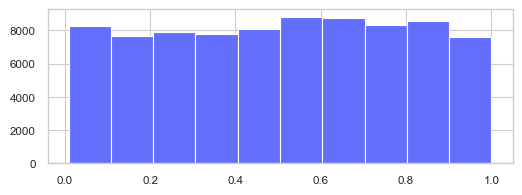

In [5]:
df_res['Morgan Tanimoto'].hist()

<AxesSubplot: >

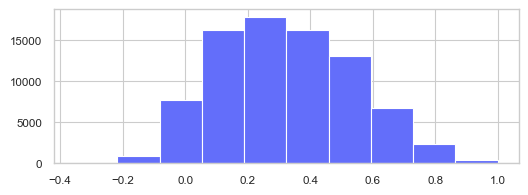

In [6]:
df_res['DreaMS'].hist()

<AxesSubplot: >

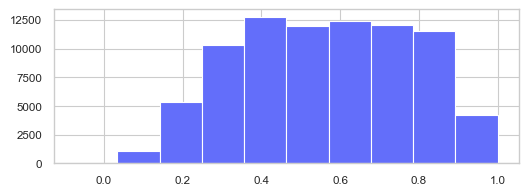

In [8]:
df_res['DreaMS zero-shot'].hist()

In [4]:
from dreams.utils.dreams import get_dreams_embeddings
model_pth = PRETRAINED / 'CtDh6OHlhA_epoch=0-step=2500.ckpt'
dreams_embs_i = get_dreams_embeddings(model=model_pth, df_spectra=df_res, spec_col='PARSED PEAKS i', prec_mz_col='PRECURSOR M/Z i', n_highest_peaks=60)
dreams_embs_j = get_dreams_embeddings(model=model_pth, df_spectra=df_res, spec_col='PARSED PEAKS j', prec_mz_col='PRECURSOR M/Z j', n_highest_peaks=60)

df_res['DreaMS zero-shot (60 peaks)'] = df_res.reset_index(drop=True).reset_index().apply(
    lambda row: F.cosine_similarity(dreams_embs_i[row['index']], dreams_embs_j[row['index']], dim=0).item()
, axis='columns')

Computing DreaMS: 100%|██████████| 3125/3125 [24:41<00:00,  2.11it/s]


In [12]:
df_res['Precursor m/z difference'] = df_res.apply(lambda row: abs(row['PRECURSOR M/Z i'] - row['PRECURSOR M/Z j']), axis='columns')

In [13]:
non_method_cols = ['index']
for c in df_res.columns:
    if c.endswith('i') or c.endswith('j'):
        non_method_cols.append(c)
df_corr_table = df_res.drop(columns=non_method_cols).corr(method='pearson')
df_corr_table

,Morgan Tanimoto,Modified cosine,Spectral entropy,MS2DeepScore,DreaMS zero-shot,DreaMS,DreaMS zero-shot (60 peaks),MCES,Precursor m/z difference
Morgan Tanimoto,1.000000,0.496979,0.583480,0.583608,0.615608,0.685264,0.625773,-0.649754,-0.243322
Modified cosine,0.496979,1.000000,0.689535,0.567483,0.530570,0.603624,0.542588,-0.350054,-0.239240
Spectral entropy,0.583480,0.689535,1.000000,0.655564,0.594262,0.711195,0.625689,-0.411309,-0.223392
MS2DeepScore,0.583608,0.567483,0.655564,1.000000,0.651201,0.643826,0.656396,-0.463613,-0.231736
DreaMS zero-shot,0.615608,0.530570,0.594262,0.651201,1.000000,0.732113,0.980996,-0.495598,-0.387974
DreaMS,0.685264,0.603624,0.711195,0.643826,0.732113,1.000000,0.751310,-0.487407,-0.300027
DreaMS zero-shot (60 peaks),0.625773,0.542588,0.625689,0.656396,0.980996,0.751310,1.000000,-0.501829,-0.379688
MCES,-0.649754,-0.350054,-0.411309,-0.463613,-0.495598,-0.487407,-0.501829,1.000000,0.564962
Precursor m/z difference,-0.243322,-0.239240,-0.223392,-0.231736,-0.387974,-0.300027,-0.379688,0.564962,1.000000


In [9]:
import seaborn as sns
from dreams.utils.plots import get_nature_hex_colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = get_nature_hex_colors()

Morgan Tanimoto
Pearson: 1.0
Spearman: 1.0
Kendall: 1.0


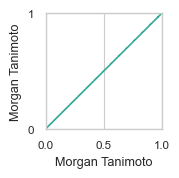

Modified cosine
Pearson: 0.511230379954392
Spearman: 0.559924404202284
Kendall: 0.38917220527265467


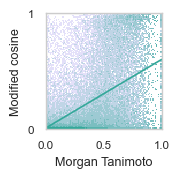

Spectral entropy
Pearson: 0.595802693782348
Spearman: 0.6224182166541631
Kendall: 0.44805259258453367


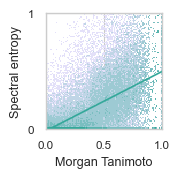

MS2DeepScore
Pearson: 0.582586127958996
Spearman: 0.5811075631470778
Kendall: 0.4069502712206302


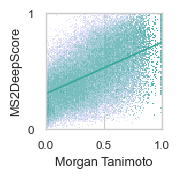

DreaMS zero-shot
Pearson: 0.6337969530337612
Spearman: 0.6289158989978386
Kendall: 0.44278783319982773


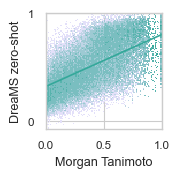

DreaMS
Pearson: 0.7030194930929037
Spearman: 0.714769939236436
Kendall: 0.5130152765891444


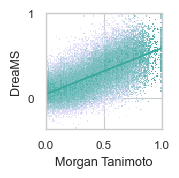

DreaMS zero-shot (60 peaks)
Pearson: 0.6436758167324884
Spearman: 0.6392246126699763
Kendall: 0.4518451498407681


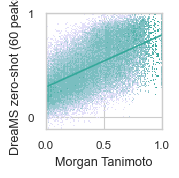

MCES
Pearson: -0.6454266891447225
Spearman: -0.7020080902218032
Kendall: -0.5210741397824379


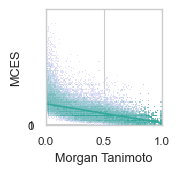

In [24]:
df_plot = df_res#[(df_res['Morgan Tanimoto'] > 0.3) & (df_res['Morgan Tanimoto'] < 0.7)]

import seaborn as sns
from dreams.utils.plots import get_nature_hex_colors, save_fig
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = get_nature_hex_colors()

for c in [c for c in df_plot.columns if c not in non_method_cols]:
    print(c)
    print('Pearson:', df_plot[c].corr(df_plot['Morgan Tanimoto'], method='pearson'))
    print('Spearman:', df_plot[c].corr(df_plot['Morgan Tanimoto'], method='spearman'))
    print('Kendall:', df_plot[c].corr(df_plot['Morgan Tanimoto'], method='kendall'))

    col_scores = df_plot[c]
    tanimoto_scores = df_plot['Morgan Tanimoto']

    init_plotting(figsize=(1.5, 1.5))
    cmap = ListedColormap(sns.blend_palette(['#E3E0F9', colors[1]], n_colors=6))
    plt.hist2d(tanimoto_scores, col_scores, bins=100, norm=matplotlib.colors.LogNorm(), cmap=cmap, alpha=1.0)#, cmap='viridis' if col != 'MS2DeepScore' else 'plasma')

    # Linear regression line
    import scipy
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(tanimoto_scores, col_scores)
    plt.plot([0, 1], [intercept, slope + intercept], colors[1])

    # cbar = plt.colorbar()
    # cbar.ax.set_ylabel('Count')
    plt.ylabel(c)
    plt.xlabel('Morgan Tanimoto')
    plt.xlim((0, 1.002))
    # plt.ylim((min(s), 1))
    plt.yticks((0, 1))
    plt.grid()
    save_fig(f'tanimoto_corr_{c.replace(" ", "_")}.svg')
    plt.show()

Morgan Tanimoto
Pearson: -0.6670749702809872
Spearman: -0.6972852518700929
Kendall: -0.5166840279597553


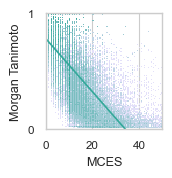

Modified cosine
Pearson: -0.37004007567520736
Spearman: -0.4410629793670471
Kendall: -0.31115385175979104


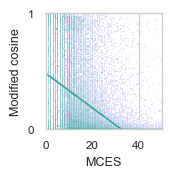

Spectral entropy
Pearson: -0.433574111018195
Spearman: -0.48415125290241356
Kendall: -0.3493726626563694


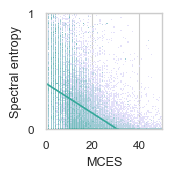

MS2DeepScore
Pearson: -0.47269779113367044
Spearman: -0.4873661814658106
Kendall: -0.3441616082470394


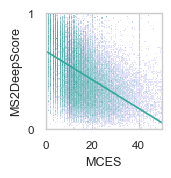

DreaMS zero-shot
Pearson: -0.5176798863349891
Spearman: -0.5264116154988718
Kendall: -0.3745329874345679


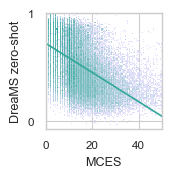

DreaMS
Pearson: -0.5142680763101497
Spearman: -0.5503326129445998
Kendall: -0.3923325728724785


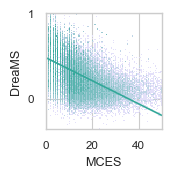

DreaMS zero-shot (60 peaks)
Pearson: -0.5227924448463857
Spearman: -0.528759066021488
Kendall: -0.37717145074144054


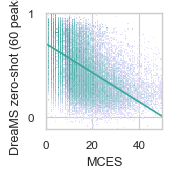

MCES
Pearson: 1.0
Spearman: 0.9999999999999999
Kendall: 1.0


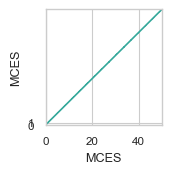

In [28]:
max_mces = 50
df_plot = df_res[df_res['MCES'] <= max_mces]#[(df_res['Morgan Tanimoto'] > 0.3) & (df_res['Morgan Tanimoto'] < 0.7)]

import seaborn as sns
from dreams.utils.plots import get_nature_hex_colors, save_fig
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
colors = get_nature_hex_colors()

for c in [c for c in df_plot.columns if c not in non_method_cols]:

    tanimoto_scores = df_plot['MCES']#df_plot['Morgan Tanimoto']
    col_scores = df_plot[c]

    print(c)
    print('Pearson:', col_scores.corr(tanimoto_scores, method='pearson'))
    print('Spearman:', col_scores.corr(tanimoto_scores, method='spearman'))
    print('Kendall:', col_scores.corr(tanimoto_scores, method='kendall'))

    init_plotting(figsize=(1.5, 1.5))
    cmap = ListedColormap(sns.blend_palette(['#E3E0F9', colors[1]], n_colors=6))
    plt.hist2d(tanimoto_scores, col_scores, bins=100, norm=matplotlib.colors.LogNorm(), cmap=cmap, alpha=1.0)#, cmap='viridis' if col != 'MS2DeepScore' else 'plasma')

    # Linear regression line
    import scipy
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(tanimoto_scores, col_scores)
    plt.plot([0, max_mces], [intercept, max_mces * slope + intercept], colors[1])

    # cbar = plt.colorbar()
    # cbar.ax.set_ylabel('Count')
    plt.ylabel(c)
    plt.xlabel('MCES')
    # plt.xlim((0, 50))
    # plt.ylim((min(s), 1))
    plt.yticks((0, 1))
    plt.grid()
    save_fig(f'mces_corr_{c.replace(" ", "_")}.svg')
    plt.show()

<AxesSubplot: >

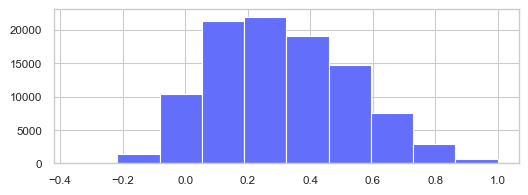

In [30]:
df_res['DreaMS'].hist()

<AxesSubplot: >

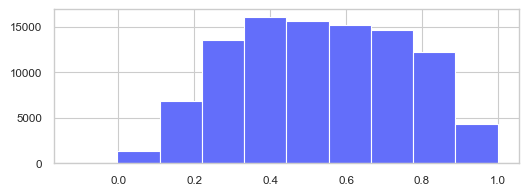

In [29]:
df_res['DreaMS zero-shot (60 peaks)'].hist()